In [177]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table
import numpy as np
import matplotlib
import matplotlib.pylab as plt

visit = 181900
filt = 'r'
butler_o = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/output")
butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/input")
dataid = {'visit':visit, 'raft':'2,2', 'sensor':'1,1'}

#fluxType = "base_PsfFlux"
fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

exp = butler_o.get('calexp', dataId = dataid)
wcs = exp.getWcs()

pt = afwGeom.Point2D(2000, 2000)
center = wcs.pixelToSky(pt)
print(center)


refConfig = LoadIndexedReferenceObjectsTask.ConfigClass()
refConfig.ref_dataset_name = 'ref_cat_protoDC2'
#refConfig.ref_dataset_name = 'ref_cat_Run1.1p'
refConfig.filterMap = {band: 'lsst_{}_smeared'.format(band) for band in 'ugrizy'}
refTask = LoadIndexedReferenceObjectsTask(butler, config=refConfig)

radius = 2.
ref = refTask.loadSkyCircle(center, afwGeom.Angle(radius, afwGeom.degrees), filt).refCat.copy(deep=True)
print("ref_cat loaded", len(ref))

IcrsCoord(55.9585344, -29.9811969)
ref_cat loaded 5037521


In [ ]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table
import numpy as np
import matplotlib
import matplotlib.pylab as plt

butler_o = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/output")

for count,data_ref in enumerate(butler_o.subset('src', visit=visit)):
#    if count > 0 :
#        break
    if data_ref.datasetExists():
        dataId = data_ref.dataId
    else:
        continue
    src = butler_o.get('src', dataId, immediate=True)

In [178]:
Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]
mag = []
ang = []
ang2 = []
star = []
ra = []
dec = []
for count,data_ref in enumerate(butler_o.subset('src', visit=visit)):
#    if count > 0 :
#        break
    if data_ref.datasetExists():
        dataId = data_ref.dataId
    else:
        continue
    src = butler_o.get('src', dataId, immediate=True)
    if count == 0:
        schema = src.getSchema()
        keyNames = schema.getNames()
        keyDict = {k:schema[k].asKey() for k in keyNames}
    match = afwTable.matchRaDec(ref, src, afwGeom.Angle(1./3600., afwGeom.degrees))
    
#    print(len(match))
    
    mdRef = butler_o.get("calexp_md", dataId, immediate=True)
    calib = afwImage.Calib(mdRef)
    
    for m in match:
        mRef = m.first
        mSrc = m.second
        reject = False
        for k in Flags :
            if mSrc.get(keyDict[k]):
                reject = True
                break
        if reject:
            continue
            
#    if mSrc.get(keyDict["calib_astrometryUsed"]):
        flux = mSrc.get(keyDict[fluxType + "_flux"])
        fluxSigma = mSrc.get(keyDict[fluxType + "_fluxSigma"])
        if flux /fluxSigma < 5 or flux < 0 :
            continue
          
        newAngle = mRef.getCoord().angularSeparation(mSrc.getCoord()).asArcseconds()*1000.
        
        mag.append(calib.getMagnitude(flux))
        ang.append(afwGeom.radToMas(m.distance))
        ang2.append(newAngle)
        star.append(mSrc.get(keyDict["base_ClassificationExtendedness_value"]))
        ra.append(mSrc.getRa())
        dec.append(mSrc.getDec())

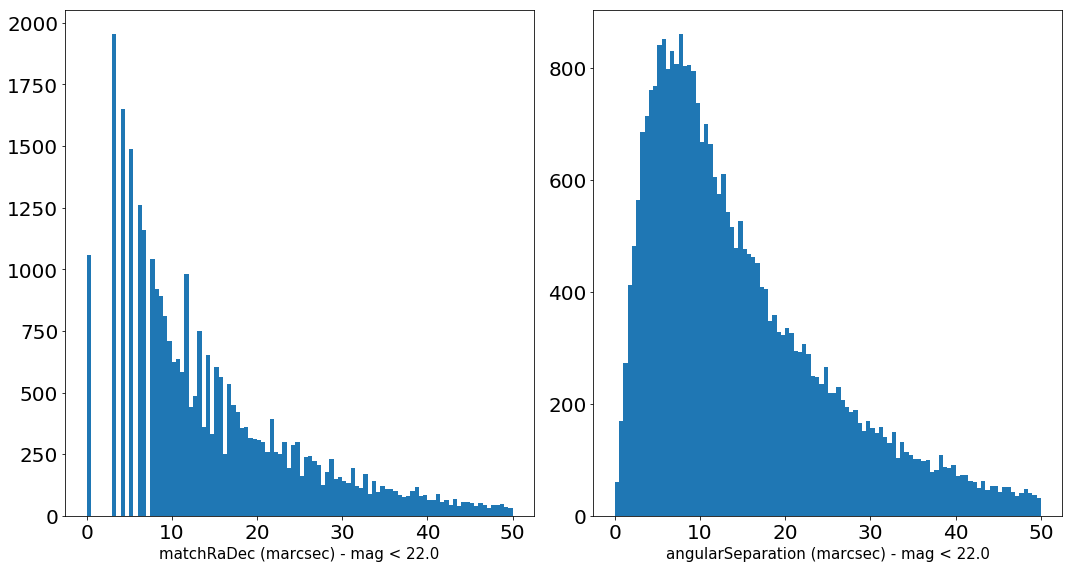

In [179]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

magLim = 22
cut = (np.asarray(mag) < magLim) & (np.asarray(star) < 0.5)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(np.asarray(ang)[cut], bins=100, range=[0.,50.])
ax0.set_xlabel("matchRaDec (marcsec) - mag < %0.1f"%(magLim), fontsize=15)
_ = ax1.hist(np.asarray(ang2)[cut], bins=100, range=[0.,50.])
ax1.set_xlabel("angularSeparation (marcsec) - mag < %0.1f"%(magLim), fontsize=15)
ax0.tick_params(labelsize=20)
ax1.tick_params(labelsize=20)
fig.tight_layout()
fig.savefig('matchRaDec_angularSeparation.png')

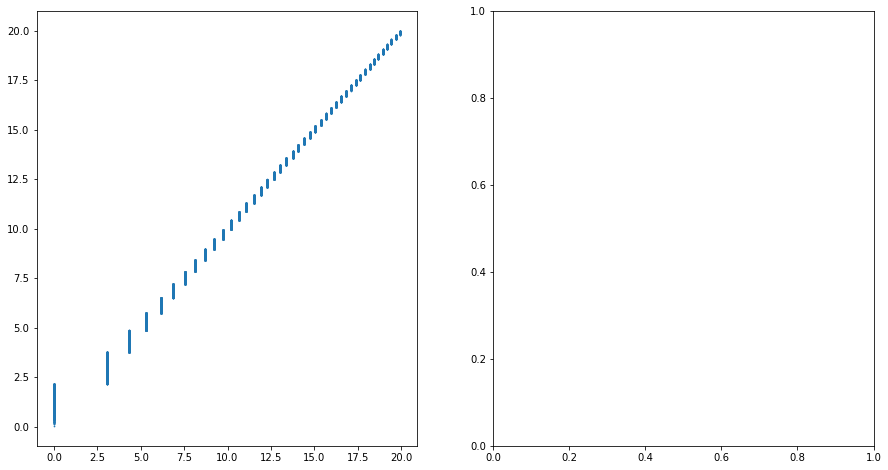

In [175]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

magLim = 22
cut2 = (np.asarray(mag) < magLim) & (np.asarray(star) < 0.5) & (np.asarray(ang2) < 20)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.scatter(np.asarray(ang)[cut2], np.asarray(ang2)[cut2], s=0.5)

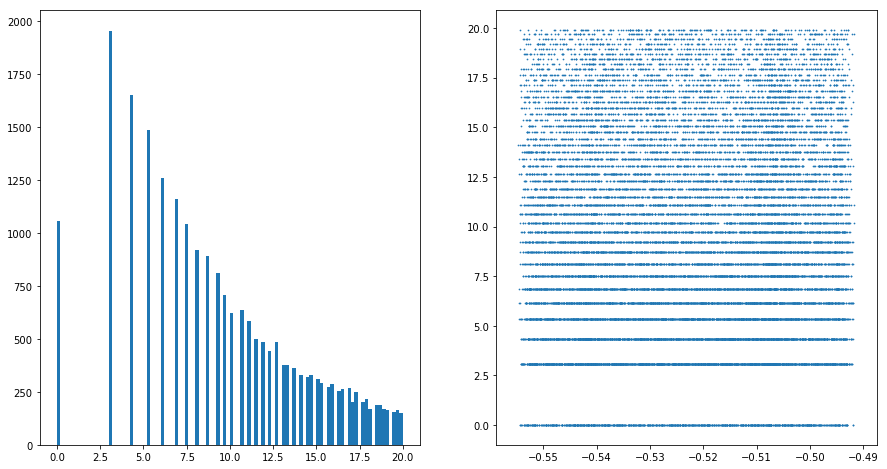

In [48]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

magLim = 22
cut = (np.asarray(mag) < magLim) & (np.asarray(star) < 0.5) & (np.asarray(ang) < 20)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(np.asarray(ang)[cut], bins=100, range=[0.,20.])
_ = ax1.scatter(np.asarray(dec)[cut], np.asarray(ang)[cut], s=0.5)

#fig.savefig('DC2_astromCheck_smear.png')

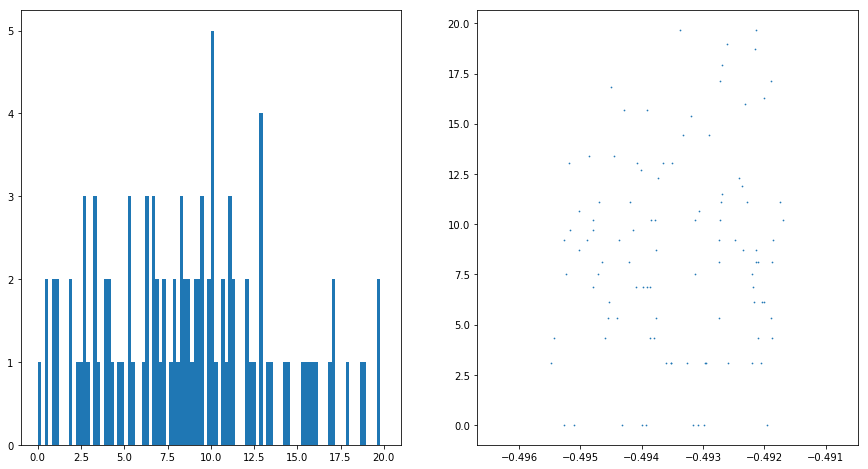

In [164]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

magLim = 22
cut = (np.asarray(mag) < magLim) & (np.asarray(star) < 0.5) & (np.asarray(ang) < 20)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(np.asarray(ang2)[cut], bins=100, range=[0.,20.])
_ = ax1.scatter(np.asarray(dec)[cut], np.asarray(ang)[cut], s=0.5)


In [ ]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(dRefRa, bins=100, range=[-1,1])
_ = ax1.hist(dRefDec, bins=100, range=[-1,1])

In [35]:
cut2 = (np.asarray(ang) < 5) & (np.asarray(ang) > 0)
print(np.asarray(ang)[cut2])

[ 3.07358513  4.34670577  3.07358513 ...,  3.07358513  3.07358513
  4.34670577]


In [ ]:
ra
#src.asAstropy()['coord_ra']

In [105]:
srcA = src.asAstropy()
refA = ref.asAstropy()
srcA

id,coord_ra,coord_dec,parent,calib_detected,calib_psfCandidate,calib_psfUsed,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,slot_Centroid_xSigma,base_SdssCentroid_ySigma,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_shapeHSM_H

In [106]:
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=srcA['coord_ra'], dec=srcA['coord_dec'])  
catalog = SkyCoord(ra=refA['coord_ra'], dec=refA['coord_dec'])  
idx, d2d, d3d = c.match_to_catalog_sky(catalog)  

In [111]:
d = (d3d*u.radian).to(u.arcsecond)
d2 = d2d.to(u.arcsecond)

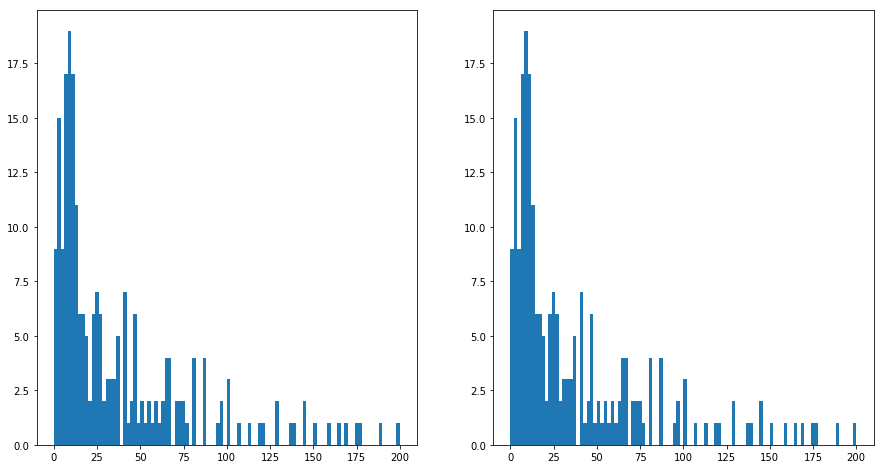

In [117]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(d*1000, bins=100, range=[0.,200.])
_ = ax1.hist(d2*1000, bins=100, range=[0.,200.])

In [141]:
diff = []
for m in match:
    mR = m.first
    mS = m.second
    newAngle = Angle(mR.getCoord().angularSeparation(mS.getCoord()).asArcseconds(), u.arcsecond)
    diff.append((Angle(m.distance, u.radian).to(u.arcsecond) - newAngle).value*1000)

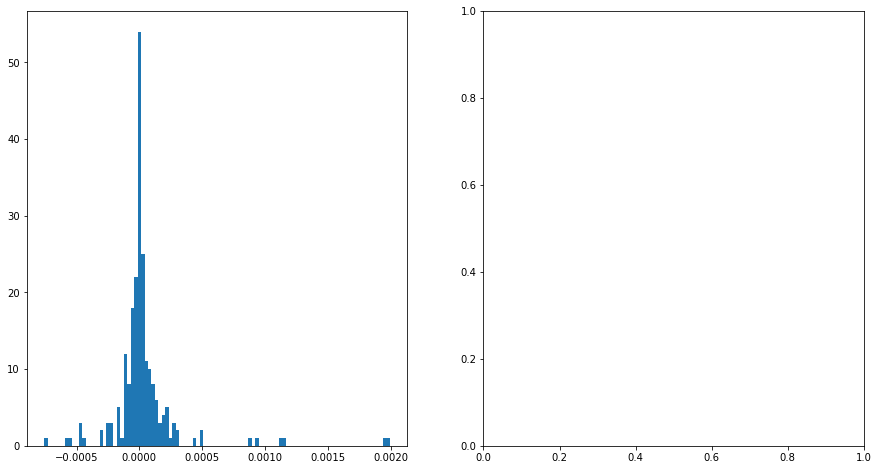

In [147]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(diff, bins=100)

In [143]:
t = mR.getCoord()

IcrsCoord(55.0692730, -28.3762092) IcrsCoord(55.0692731, -28.3762091)
IcrsCoord(55.1238371, -28.3672666) IcrsCoord(55.1238371, -28.3672663)
IcrsCoord(54.9294346, -28.3228899) IcrsCoord(54.9294350, -28.3228899)
IcrsCoord(55.0659746, -28.3037053) IcrsCoord(55.0659747, -28.3037054)
IcrsCoord(55.0422876, -28.3001715) IcrsCoord(55.0422870, -28.3001715)
IcrsCoord(55.0564411, -28.2558701) IcrsCoord(55.0564411, -28.2558701)
IcrsCoord(55.0614430, -28.2519240) IcrsCoord(55.0614432, -28.2519242)
IcrsCoord(55.0964442, -28.2455054) IcrsCoord(55.0964445, -28.2455053)
IcrsCoord(55.0128751, -28.1870500) IcrsCoord(55.0128746, -28.1870503)


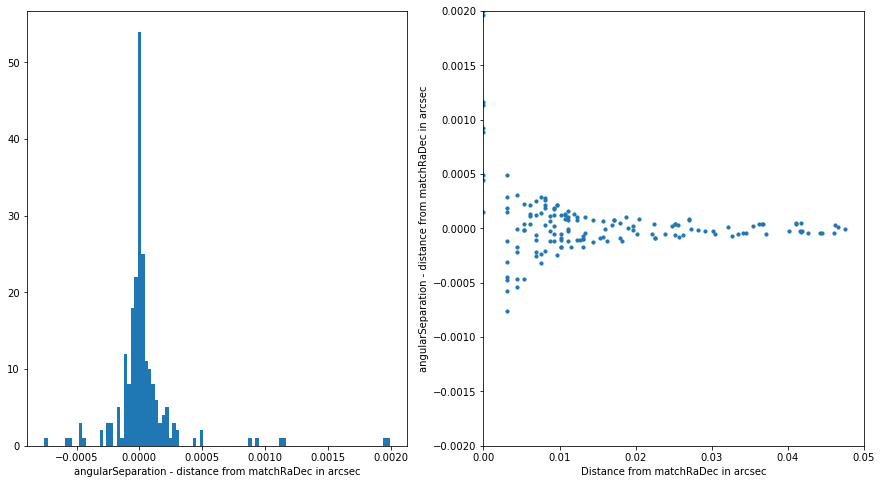

In [161]:
diff = []
ang = []
for m in match:
    mR = m.first
    mS = m.second
    angle1 = mR.getCoord().angularSeparation(mS.getCoord()).asArcseconds()
    angle2 = afwGeom.Angle(m.distance).asArcseconds()
    diff.append(angle1-angle2)
    ang.append(angle2)
    
    if angle2 == 0:
        print(mR.getCoord(), mS.getCoord())
    
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(diff, bins=100)
_ = ax1.scatter(ang, diff, s=10)
ax0.set_xlabel('angularSeparation - distance from matchRaDec in arcsec')
ax1.set_xlim([0, 0.05])
ax1.set_ylim([-0.002, 0.002])
ax1.set_xlabel('Distance from matchRaDec in arcsec')
ax1.set_ylabel('angularSeparation - distance from matchRaDec in arcsec')
fig.savefig('Match problem.png')

In [ ]:
positions[n].x = std::cos(ra) * cosDec;
positions[n].y = std::sin(ra) * cosDec;
positions[n].z = std::sin(dec);